# Subpopulation Discovery in Bladder Cancer Proteomics (Level 1)
This notebook identifies patterns in a bladder cancer proteomics dataset using unsupervised learning.

Course: Omics for Non-Biologists
Group name: Genomics

Group members:

- Ke Wang
- Carla Malo
- Marc Nanzer
- Jiayi Ma
- Choekyel Nyungmartsang

Expected input files

- ../data/proteomics.txt (required): protein abundance matrix
- ../data/metadata.csv (optional): clinical metadata
- ./src/ (required): helper functions used in this notebook

Dataset

- 140 patients
- 3,120 proteins
- Each value represents the measured abundance of one protein in one patient

Level 1 goal

- Build an unsupervised pipeline to group patients into clusters based on their protein profiles
- Justify the number of clusters using quantitative metrics and visual evidence

Planned approach

- Reduce dimensionality using PCA
- Apply KMeans clustering in the reduced space
- Evaluate clustering using elbow analysis, silhouette scores, and 2D visualizations (PCA and UMAP)

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score
from sklearn.covariance import LedoitWolf

REQUIRED_FILES = ["proteomics.txt"]
for f in REQUIRED_FILES:
    if not os.path.exists(f):
        raise FileNotFoundError(f"Missing required input file: {f}")

if not os.path.isdir("./src"):
    raise FileNotFoundError(
        "Missing required folder './src'. "
        "Please include the 'src' directory containing 'bladder_proteomics' with the submission."
    )

from src.bladder_proteomics.utils import load_data, validate_data
from src.bladder_proteomics.preprocessing import log1p_transform, zscore_normalize, variance_filter, log2_transform, median_center_rows
from src.bladder_proteomics.dimensionality_reduction import apply_pca, pca_elbow, apply_umap, pc_names, compare_pca_diagnostics
from src.bladder_proteomics.clustering import kmeans_cluster
from src.bladder_proteomics.k_selection import elbow_method, silhouette_analysis, calculate_elbow_point, evaluate_k_selection_one, ari_stability_init, passes_min_cluster_size, pc_sensitivity_best_k
from src.bladder_proteomics.plotting import (get_cluster_colors, plot_2d_embedding,
                          plot_cluster_distributions, plot_cluster_sizes,
                          plot_clusters, plot_elbow, plot_heatmap,
                          plot_log10_raw_distribution,
                          plot_median_centering_diagnostics, plot_pca,
                          plot_pca_cumulative_variance,
                          plot_pca_scatter_with_outliers, plot_pca_variance,
                          plot_scree_and_cumulative, plot_silhouette_scores,
                          plot_umap, set_plot_style, plot_k_selection_grid,
                          overlay_flagged_outliers_on_clean_pca)
set_plot_style(dpi=120)

1. Data overview and preprocessing

Data orientation
- The proteomics file is loaded as a table with rows = patients and columns = proteins.

Preprocessing goals
- Make abundance values comparable across proteins and patients.
- Reduce the number of uninformative or redundant protein features before clustering.

Steps

1. Load the proteomics matrix and run basic validation checks (shape, missingness, duplicates, value range).
2. Remove protein features with identical expression profiles across patients (redundant features).
3. Visualize the raw dynamic range using a log10 histogram (diagnostic only).
4. Apply a log2 transform to compress the dynamic range (only valid for non-negative values).
    - If zeros exist, add a small pseudo-count; otherwise use log2(x) without an offset.
5. Normalize each patient by median centering on the log2 scale to reduce global sample-to-sample intensity shifts.
6. Remove (near) constant proteins and select the top 20 most variable proteins on the log2 scale.
7. Standardize selected proteins (z score per protein) so PCA and KMeans are driven by patterns rather than measurement scale.
8. Select variables for metadata and standardize
9. Combine proteomics and metadata
10. Fit PCA and compute Mahalanobis distance in PCA space to flag potential outlier patients for sensitivity analysis.

Notes on key choices

- Log2 transform: Raw proteomics values span a very large range. Log2 compresses extremes and is common in proteomics (fold changes become interpretable on a base-2 scale).
- Median centering (sample-level): Proteomics samples can differ in overall intensity due to technical effects (loading amount, instrument drift). Median centering reduces global shifts so clustering focuses more on relative protein patterns. This may also remove real biological “global intensity” effects, so we treat it as a practical normalization choice and report sensitivity checks.
- Feature selection (top 20% by variance): We reduce dimensionality by keeping proteins that vary most across patients on the log2 scale. This is mainly for denoising and dimensionality reduction.

In [3]:
# Load + validate
df = load_data("proteomics.txt", transpose=True, index_col=0, sep="\t")
validate_data(df) # each patient is now a column
print(f"Raw value range: min={df.min().min():.4g}, max={df.max().max():.4g}")

Removed proteins with identical profiles: 9
Data shape (samples × features): (140, 3112)
Missing values: 0
Duplicate rows: 0 | Duplicate columns: 0
Raw value range: min=1.163, max=7.19e+20


The raw protein abundances span a very large dynamic range (up to ~7e20).
To make patterns comparable across patients and reduce the impact of extreme values, we transform the data to a log scale.
We use log2 because it is commonly used in proteomics (fold changes become interpretable on a base 2 scale).

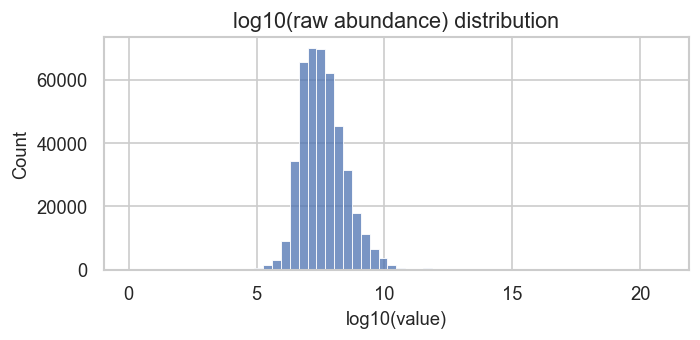

In [4]:
# log10(raw) distribution (interpretable dynamic range)
plot_log10_raw_distribution(df)
plt.tight_layout()
plt.show()

Figure: Histogram of log10-transformed raw abundance values pooled across all proteins and patients.
This is a quick diagnostic to show the extreme dynamic range of the raw measurements and motivate log-scale preprocessing.
All downstream preprocessing uses a log2 transformation for interpretability.

In [5]:
# log2 transform
df_log2, log_info = log2_transform(df, pseudocount="auto")
print("log2 transform info:", log_info)

log2 transform info: {'has_zero': 0.0, 'pseudocount_used': 0.0}


# Sample-level normalization: median centering (log2 scale)
To reduce global sample-to-sample intensity shifts, we subtract each patient’s median log2 abundance from all proteins in that patient.

We show:

- the distribution of per-patient median log2 intensities before centering
and that these medians are aligned around zero after centering (by construction)
- A more informative visualization (density curves across several patients) can be seen in the Supplement section S1A.

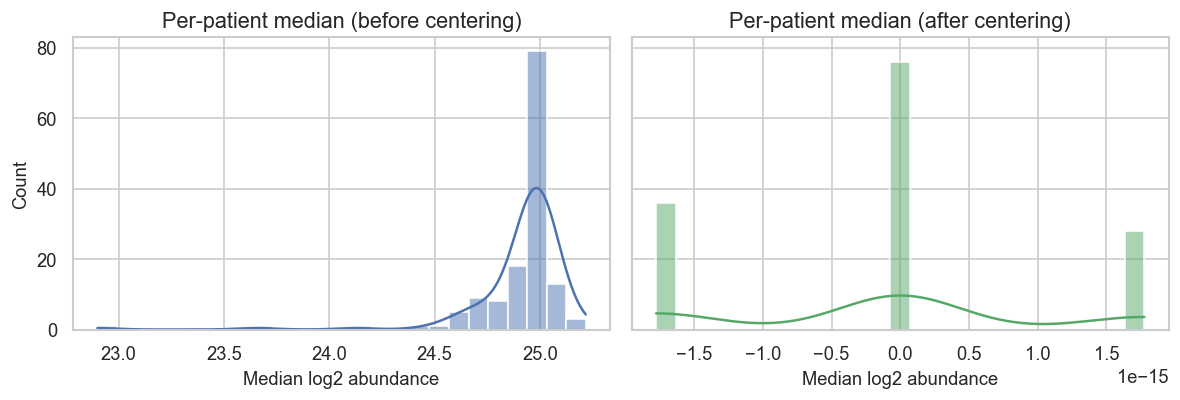

In [6]:
# median centering + diagnostic plots
df_log2_before = df_log2.copy()
df_log2 = median_center_rows(df_log2)
fig1 = plot_median_centering_diagnostics(df_log2_before, df_log2)
plt.show()

Figure: Diagnostic plots for median centering on the log2 scale.
Left: per patient median log2 intensity before centering. Right: after centering the median is aligned around zero by construction.

The density curves in the supplementary section show that centering reduces global intensity shifts across patients while keeping the overall shape of protein distributions similar.

We select the top 20 percent most variable proteins before z score scaling, because z scoring would force all proteins to have similar variance and would remove the basis for variance based feature selection.

In [7]:
# Feature selection: top 20 by variance on log scale
top_fraction = 0.0065
variances = df_log2.var(axis=0).sort_values(ascending=False) # variance per protein and sort form highest to lowest variance

# in total we have 3112 proteins and we want to select only the top 20

k = max(2, int(len(variances) * top_fraction)) # decide how many proteins to keep (20)
top_features = variances.index[:k]
df_sel_log = df_log2.loc[:, top_features].copy() # keep all rows (patients) but keep only top proteins (columns)
print(f"After feature selection (top {int(top_fraction*100)}% by variance): {df_sel_log.shape}")

After feature selection (top 0% by variance): (140, 20)


In [8]:
# Z-score per protein for PCA/KMeans
df_scaled = zscore_normalize(df_sel_log, axis=0)

Now that we have scaled the proteomics data, we will now select and scale the metadata so that we can then combine them

In [13]:
metadata_df = pd.read_csv("metadata.csv")
metadata_df = metadata_df.set_index("Patient_ID")

Variables we consider, because we think that they are relevant to determine relevant patient subpopulations:
* age: patient intrinsic factor influencing tumor progression
* tumor_size: direct measure of severity
* metastasis: indicator of disease spread
* family_history_of_cancer: genetic risk factor
* smoking_history: known cancer risk factor
* histological_grade: reflects aggressiveness

In [10]:
meta_cols = [
    "Age",
    "Tumor_Size_mm",
    "Metastasis",
    "Family_History_of_Cancer",
    "Smoking_History",
    "Histological_Grade"
]

In [14]:
metadata_df_used = metadata_df[meta_cols].copy()

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

metadata_df_used["Age_scaled"] = scaler.fit_transform(metadata_df_used[["Age"]])
metadata_df_used["Tumor_Size_mm_scaled"] = scaler.fit_transform(metadata_df_used[["Tumor_Size_mm"]])
metadata_df_used["Metastasis_encoded"] = metadata_df_used["Metastasis"].map({"Yes": 1, "No": 0})
metadata_df_used["Family_History_encoded"] = metadata_df_used["Family_History_of_Cancer"].map({"Yes": 1, "No": 0})
metadata_df_used["Smoking_encoded"] = metadata_df_used["Smoking_History"].map({"Yes": 1, "No": 0})
grade_map = {"Low": 1, "Intermediate": 2, "High": 3}
metadata_df_used["Grade_encoded"] = metadata_df_used["Histological_Grade"].map(grade_map)

In [16]:
metadata_df_used_scaled = metadata_df_used.copy()
metadata_df_used_scaled = metadata_df_used_scaled.drop(columns=[
        "Age",
        "Tumor_Size_mm",
        "Metastasis",
        "Family_History_of_Cancer",
        "Smoking_History",
        "Histological_Grade"
    ]
)
metadata_df_used_scaled.head()
metadata_df_used_scaled.shape

(140, 6)

Now we can combine the metadata and proteomics data

In [17]:
combined_df_proteomics_metadata = pd.concat([df_scaled, metadata_df_used_scaled], axis = 1)
combined_df_proteomics_metadata.head()
combined_df_proteomics_metadata.shape

(140, 26)

Now we can make a pca plot of the combined data

In [18]:
pca_var_target = 0.8 # get enough pcs to explain ~80% of the total variance
pca_df, pca_model = apply_pca(combined_df_proteomics_metadata, n_components=pca_var_target, return_model=True)
pca_df = pc_names(pca_df)

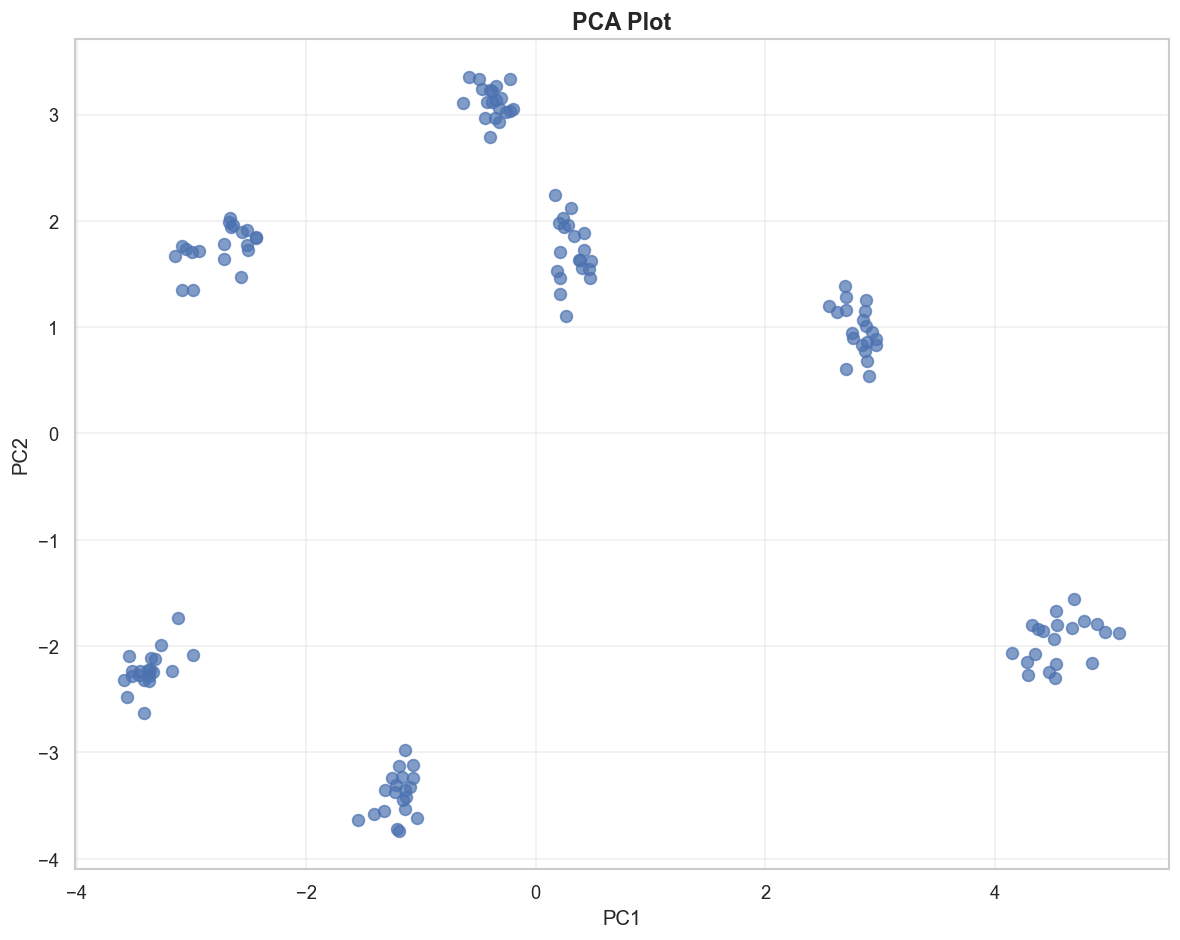

In [19]:
# PCA scatter
pca2 = pca_df.iloc[:, :2].copy()  # already PC1/PC2 if pc_names applied
plot_pca(pca2)
plt.tight_layout()
plt.show()